In [0]:
from google.colab import drive

######### change below 2 directories to whatever you're using
colab_dir='/content/drive/My Drive/Colab Notebooks/'
dir_peaks = '/content/drive/My Drive/Colab Notebooks/MnuLFI_Jul19/'

######### 
h = 0.2 ## derivative step for score compression


In [2]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
!pip install git+https://github.com/justinalsing/pydelfi.git
!pip install git+https://github.com/dfm/corner.py.git

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pydelfi.priors as priors
import pydelfi.score as score
%matplotlib inline
from scipy import *
from pylab import *
import corner
import pickle
import os

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C

In [5]:
############### load all the peak data, not processed
theta_fiducial=array([0.1,0.3,2.1])

fgp = os.path.join(dir_peaks, 'GP.peakcnt.p') 
meta = pickle.load(open(fgp, 'rb'))

peakcnt_fid = pickle.load(open(dir_peaks+'peakcounts.fiducial.p', 'rb'))  ### not scaled!
peakcnts = peakcnt_fid['peakcounts']  
data_cov = peakcnts

def myGPwrap(_theta, meta=meta):  
    ''' wrapper for GP. Given theta, returns all 50 bin peakcounts and sigma
    '''
    _scaling, gp_list = meta # unpack meta data 

    preds = np.zeros(50) 
    for i, gp in enumerate(gp_list):
        pred, sigma = gp.predict(np.atleast_2d(_theta), return_std=True)
        preds[i] = pred[0] 
    preds *= np.array(_scaling) 
    return preds 

params = np.load(dir_peaks+'params.npy')
data_mean = np.load(dir_peaks+'data_scaled_full_set_means.npy')
mu = data_mean[51]

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [6]:
############## compressed data with full 50 bins
def compress_data (gp, data_cov, h=h, mu=mu):
  theta_der = array([theta_fiducial*x for x in (1+h*identity(3))])
  dmu = array([gp(theta) for theta in theta_der])
  dmudt = dmu/(h*theta_fiducial.reshape(3,-1))

  Cinv = array(mat(12.25/2e4*cov(data_cov,rowvar=0)).I)## shrunk to LSST

  ########## compress data
  Compressor = score.Gaussian(len(mu), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
  Compressor.compute_fisher()## need to make sure Cinv is not matrix
  Finv = Compressor.Finv

  def compressor(d, compressor_args=None):
      return Compressor.scoreMLE(d)

  def gp_compress (theta):
    return compressor(gp(theta))

  data_cov_compressed = array([list(map(compressor, data_cov))]).squeeze()
  Cinv_compressed = array(mat(12.25/2e4*cov(data_cov_compressed,rowvar=0)).I)
  return gp_compress, Cinv_compressed

covI50 = array(mat(12.25/2e4*cov(data_cov,rowvar=0)).I)
GPcomp_50, covcompI50  = compress_data (myGPwrap, data_cov)

GP50 = myGPwrap

yes


In [12]:
############ nesar's PCA, with either 3 or 10 components

from sklearn.decomposition import PCA
print ("PCA components: %s"%(nComp))

########################### PCA #############################
def PCA_compress(x, nComp=nComp):
    # x is in shape (nCosmology, nbins)
    pca_model = PCA(n_components=nComp)
    principalComponents = pca_model.fit_transform(x)
#     pca_bases = pca_model.components_
#     print("original shape:   ", x.shape)
#     print("transformed shape:", principalComponents.shape)
#     print("bases shape:", pca_bases.shape)
    
    return pca_model#, np.array(principalComponents), np.array(pca_bases)

######### just do once
pca_model =  PCA_compress(data_cov)
pickle.dump(pca_model, open( dir_peaks + 'PCA_model' + str(nComp), 'wb'))

##### get PCA model
pca_model = pickle.load(open(dir_peaks + 'PCA_model' + str(nComp), 'rb'))
pred_compress = lambda preds: pca_model.transform(np.expand_dims(preds, axis=0)) ###preds has 50 bins

GP_pca = lambda theta: pred_compress(myGPwrap(theta))
data_cov_pca = array([list(map(pred_compress, data_cov))]).squeeze()
Cinv_pca = array(mat(12.25/2e4*cov(data_cov_pca,rowvar=0)).I)

## GP_pca, Cinv_pca
print (GP_pca(theta_fiducial)) ######## pass

[[ -321.56031285 -1220.79675042  -120.33842943]]


In [13]:
############### likelihood
#from emcee.utils import MPIPool 
import multiprocessing as mp
import emcee

ndim=3
Nchain=100

nwalkers=100
burn_in_chain=200
main_chain=1000

thetas = params
prior_range = np.array([[thetas[:,i].min(), thetas[:,i].max()] for i in range(thetas.shape[1])])

def lnprior(tt): 
  ''' log uniform prior 
        '''
  t0, t1, t2 = tt 
  if (prior_range[0][0] <= t0 <= prior_range[0][1]) and (prior_range[1][0] <= t1 <= prior_range[1][1]) and (prior_range[2][0] <= t2 <= prior_range[2][1]):
    return 0.0 
  return -np.inf 

  
lnprob_input_arr = [[[GP50,  GPcomp_50, GP_pca][i], 
                   [GP50, GPcomp_50, GP_pca][i](theta_fiducial),
                   [covI50, covcompI50, Cinv_pca][i]] for i in range(3)] #
fns = ['full','score_%.2f'%(h),'pca_%i'%(nComp)]#

def lnprob(theta, i):
    '''log likelihood '''
    iGP, iobs, icovI = lnprob_input_arr[i]
    if theta[0]<0: ####### force neutrino mass to be positive
        return -np.inf
    diff = iGP(theta)-iobs
    return float(-0.5*mat(diff)*icovI*mat(diff).T) + lnprior(theta)

############ initial walker
p0 = [np.random.uniform(prior_range[:,0], prior_range[:,1]) for i in range(nwalkers)]

########### MCMC sampler
pool=MPIPool()
if not pool.is_master():
    pool.wait()
    sys.exit(0)
pool = mp.Pool(100)

for i in range(len(fns)):
  sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[i,], pool=pool)
  ########### BURN
#   pos, prob, state = sampler.run_mcmc(p0, burn_in_chain)
#   print (i, 'done burn')
#   sampler.reset()
#   sampler.run_mcmc(pos, main_chain)
  sampler.run_mcmc(p0, main_chain)
  save(colab_dir+'MCMC_%s.npy'%(fns[i]), sampler.flatchain)
  print (i, 'done chain')

2 done chain


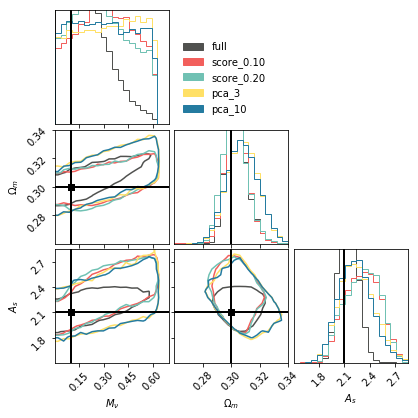

In [18]:
########### plotting
from matplotlib import colors


#labels_arr = fns
########## this is using pre-run chains

labels_arr = ['full','score_0.10','score_0.20','pca_3','pca_10']
hex_all = ['#50514F','#F25F5C','#70C1B3','#FFE066','#247BA0']

MC_arr = [load(colab_dir+'MCMC_%s.npy'%(ifn)) for ifn in labels_arr]

def plotmc(chain, f=None, icolor='k',range=[[0,0.7],[0.26,0.34],[1.5,2.85]], fill=0):
  corner.corner(chain[int(len(chain)/4):], labels=[r"$M_\nu$", r"$\Omega_m$", r"$A_s$"],
                levels=[0.95,], 
                color=icolor,
                range=range, truths=theta_fiducial, fig=f, 
                plot_datapoints=0, plot_density=0,
                truth_color="k", fill_contours=fill)#
    
def plot_contour(MC_arr):
  clrs_all = [colors.hex2color(ihex) for ihex in hex_all]
  proxy=[plt.Rectangle((0,0),1,0.5, ec=icolor, fc = icolor) for icolor in clrs_all]

  f,ax=subplots(3,3,figsize=(6,6))
  for j in range(len(MC_arr)):
      plotmc(MC_arr[j],f=f, icolor=hex_all[j])
  ax[0,1].legend(proxy,labels_arr,fontsize=10,frameon=0,
                 loc='lower left')
  show()
#   savefig(colab_dir+'contour_score.pdf')
#   close()

plot_contour(MC_arr)